<a href="https://colab.research.google.com/github/Rogerio-mack/IMT_CD_2025/blob/main/IMT_Exemplo_ARIMA_xx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **$ARIMA(p,d,q)$**



# **CASE:** Emissões de CO2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.datasets import co2
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


# 1. Data, Pré-Processamento

Exiba a série de dados como abaixo.

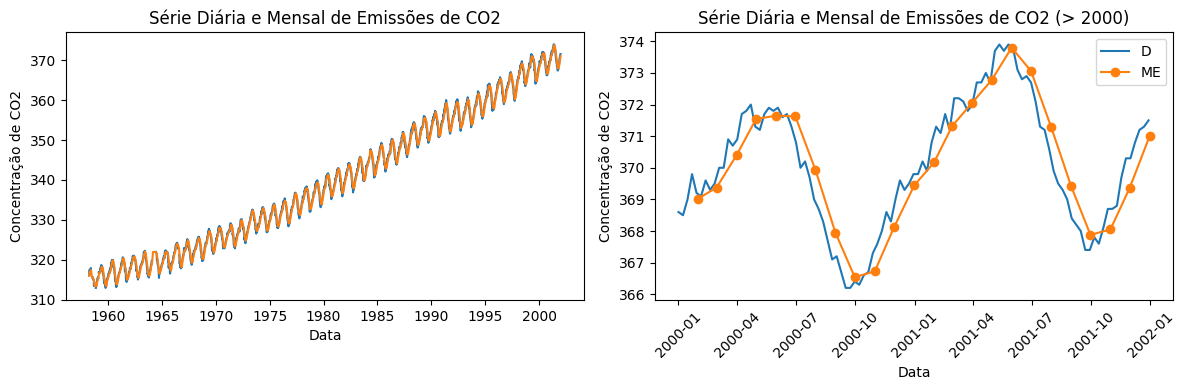

In [8]:
df = co2.load_pandas().data

data = df.resample('ME').mean()
data = data.fillna(data.bfill())
ts = data['co2']

plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(df,label='D')
plt.plot(ts,label='ME')
plt.title('Série Diária e Mensal de Emissões de CO2')
plt.xlabel('Data')
plt.ylabel('Concentração de CO2')

plt.subplot(1, 2, 2)
plt.plot(df[ df.index >= pd.to_datetime('2000-01-01') ],label='D')
plt.plot(ts[ ts.index >= pd.to_datetime('2000-01-01') ],label='ME',marker='o')
plt.title('Série Diária e Mensal de Emissões de CO2 (> 2000)')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Concentração de CO2')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


# 2. Exploração da Série, Decomposição

Faça a decomposição da Série mensal.

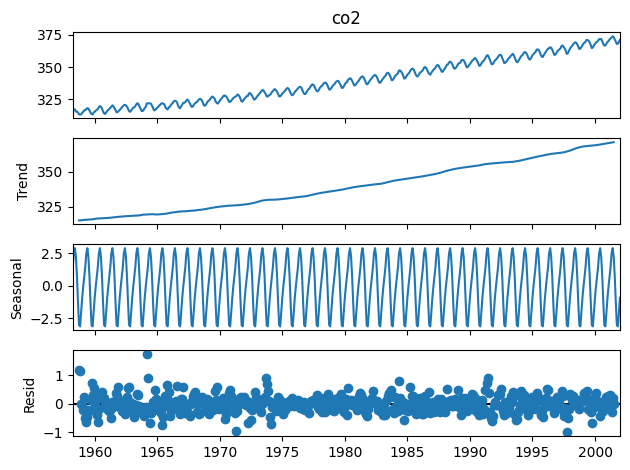

In [9]:
decomposition = seasonal_decompose(ts)

fig = decomposition.plot()
plt.show()

# 2. Teste de estacionariedade (Dickey-Fuller Aumentado - ADF), **$d$**

Verifique se a Série Mensal é estacionária e determine o parâmetro $d$.

In [10]:
def adf_test(series):
    result = adfuller(series)
    print('Teste ADF:')
    print(f'Estatística ADF: {result[0]}')
    print(f'Valor-p: {result[1]}')
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    if result[1] <= 0.05:
        print('A série temporal é estacionária (rejeita H0)')
    else:
        print('A série temporal não é estacionária (falha em rejeitar H0)')
    return result[1]

adf_result = adf_test(ts)

Teste ADF:
Estatística ADF: 2.3598099539953528
Valor-p: 0.9989901230798025
Valores Críticos:
	1%: -3.4432119442564324
	5%: -2.8672126791646955
	10%: -2.569791324979607
A série temporal não é estacionária (falha em rejeitar H0)


In [11]:
if adf_result > 0.05:
    ts_diff = ts.diff().dropna()
    print("\nTeste ADF após diferenciação:")
    adf_test(ts_diff)
else:
    ts_diff = ts



Teste ADF após diferenciação:
Teste ADF:
Estatística ADF: -5.063202630318541
Valor-p: 1.6614851317682985e-05
Valores Críticos:
	1%: -3.4432119442564324
	5%: -2.8672126791646955
	10%: -2.569791324979607
A série temporal é estacionária (rejeita H0)


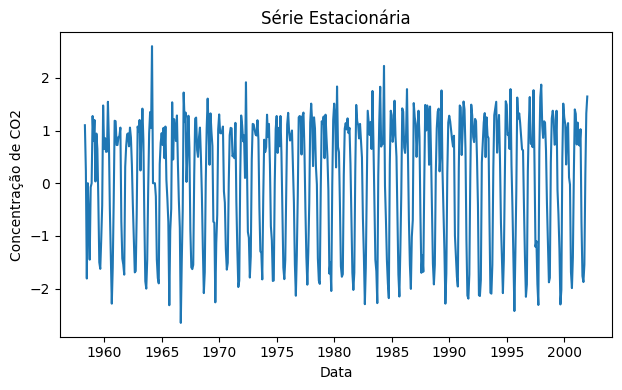

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(ts_diff)
plt.title('Série Estacionária')
plt.xlabel('Data')
plt.ylabel('Concentração de CO2')

plt.tight_layout()
plt.show()

# 3. Auto-correlação e Correlação Parcial, ACF e PACF, **$q, p$**

Deteremine os parâmetros $p$ (parte autoregressiva AR) e $q$ (parte média móvel MA) do modelo ARIMA.

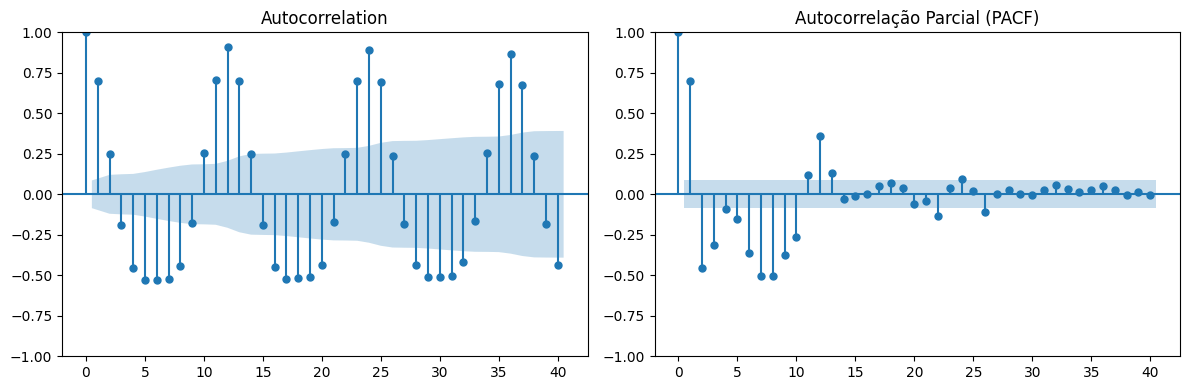

In [ ]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(12, 4))

plot_acf(ts_diff, lags=40, ax=ax1)
ax2.set_title('Autocorrelação (ACF)')

plot_pacf(ts_diff, lags=40, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()



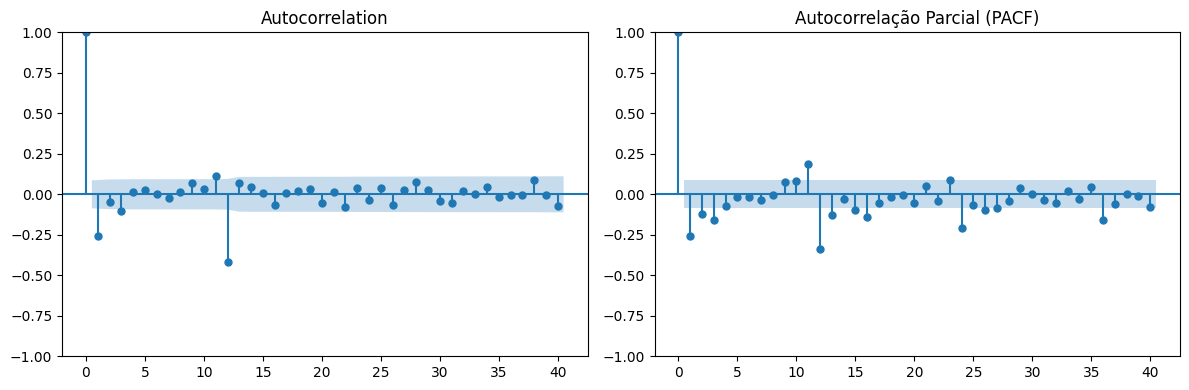

In [ ]:
# Diferenciação sazonal (por exemplo, mensal com sazonalidade anual s=12)
ts_diff_seasonal = ts_diff.diff(12).dropna()  # D = 1, s = 12

fig, [ax1, ax2] = plt.subplots(1,2,figsize=(12, 4))

plot_acf(ts_diff_seasonal, lags=40, ax=ax1)
ax2.set_title('Autocorrelação (ACF)')

plot_pacf(ts_diff_seasonal, lags=40, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()

# 4. Forecast,

Faça o modelo ARIMA de previsão dos 20% finais da série. Analise os resíduos e erro obtido.

                                    SARIMAX Results                                     
Dep. Variable:                              co2   No. Observations:                  420
Model:             ARIMA(3, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -143.572
Date:                          Wed, 28 May 2025   AIC                            299.143
Time:                                  23:30:07   BIC                            323.196
Sample:                              03-31-1958   HQIC                           308.662
                                   - 02-28-1993                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2914      0.141      2.060      0.039       0.014       0.569
ar.L2         -0.0149      0.059     -0.251      0.

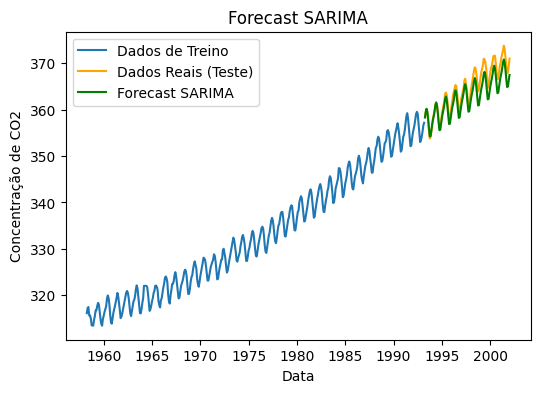

In [14]:
train_size = int(len(ts) * 0.8)
train, test = ts[0:train_size], ts[train_size:]

order = (3, 1, 1)              # (p, d, q) não-sazonal
seasonal_order = (0, 1, 1, 12) # (P, D, Q, s) sazonal

# Treinar o modelo SARIMA
model = ARIMA(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

print(model_fit.summary())

# Fazer o forecast
forecast_steps = len(test)

# forecast = model_fit.forecast(steps=forecast_steps) # Esta é a forma antiga
# Usar predict para um forecast mais robusto com índices
forecast = model_fit.predict(start=test.index[0], end=test.index[-1])

# Visualizar o forecast
plt.figure(figsize=(6,4))
plt.plot(train.index, train, label='Dados de Treino')
plt.plot(test.index, test, label='Dados Reais (Teste)', color='orange')
plt.plot(test.index, forecast, label='Forecast SARIMA', color='green')
plt.title('Forecast SARIMA')
plt.xlabel('Data')
plt.ylabel('Concentração de CO2')
plt.legend()
plt.show()



## Análise dos Resíduos

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calcular o RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'RMSE do conjunto de teste: {rmse:.2f}')

RMSE do conjunto de teste: 2.11


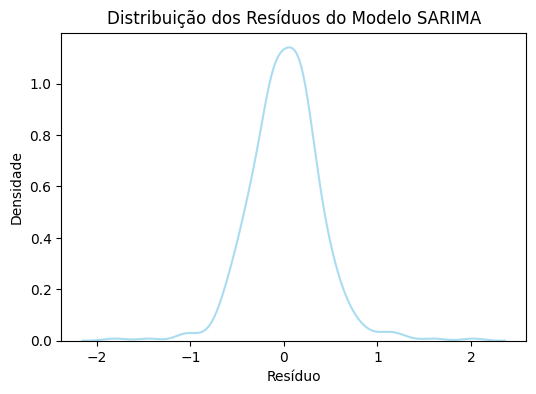

In [16]:
residuals = model_fit.resid

plt.figure(figsize=(6, 4))
sns.kdeplot(residuals[ np.abs(residuals) < 100 ], alpha=0.7, color='skyblue')
plt.title('Distribuição dos Resíduos do Modelo SARIMA')
plt.xlabel('Resíduo')
plt.ylabel('Densidade')
# plt.xlim(-30, 30)

plt.show()

<Figure size 600x400 with 0 Axes>

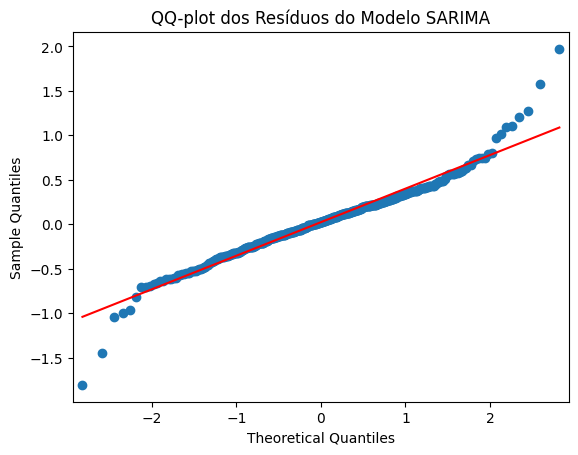

In [ ]:
from statsmodels.graphics.api import qqplot
from matplotlib import pyplot

# Gerar o QQ-plot dos resíduos
plt.figure(figsize=(6,4))
qqplot(residuals[ np.abs(residuals) < 100 ], line='r')
plt.title('QQ-plot dos Resíduos do Modelo SARIMA')
pyplot.show()

In [ ]:
from scipy.stats import jarque_bera

# Teste de Jarque-Bera
# H₀ (nula): os resíduos têm distribuição normal.
jb_stat, jb_pvalue = jarque_bera(residuals[2:-2])

print(f'Teste de Jarque-Bera para Normalidade dos Resíduos:')
print(f'Estatística de teste: {jb_stat:.4f}')
print(f'Valor-p: {jb_pvalue:.4f}')
if jb_pvalue > 0.05:
    print('Os resíduos parecem ser normalmente distribuídos (não rejeitar H0)')
else:
    print('Os resíduos não parecem ser normalmente distribuídos (rejeita H0)')

Teste de Jarque-Bera para Normalidade dos Resíduos:
Estatística de teste: 2928352.6360
Valor-p: 0.0000
Os resíduos não parecem ser normalmente distribuídos (rejeita H0)


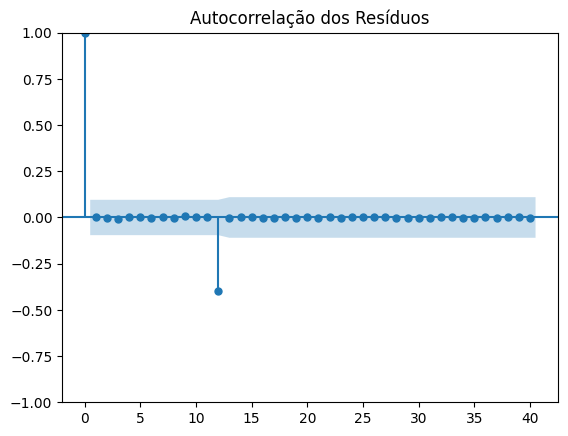

In [ ]:
# Testar a autocorrelação dos resíduos (idealmente, os resíduos não devem ser correlacionados)
plot_acf(residuals, lags=40)
plt.title('Autocorrelação dos Resíduos')
plt.show()

# 5. Seleção de Vários Modelos

Selecione um melhor modelo ARIMA.